In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner
import os

### The goal of this notebook is to see how effective our pybmc packages are doing

In [95]:
import importlib
import dataset_trial2
import bmc
importlib.reload(dataset_trial2)
importlib.reload(bmc)

from dataset_trial2 import Dataset
from bmc import BayesianModelCombination

The number of common isotopes are(629, 2)isotopes
The number of selected stable isotopes are(167, 2)isotopes
       N    Z    ME2  MEdelta    PC1   NL3S      SKMS       SKP      SLY4  \
0      8    8  2.729    2.691  2.747  2.735  2.794203  2.824011  2.795792   
1     10    8  2.733    2.704  2.749  2.728  2.793734  2.825080  2.799074   
2     12    8  2.743    2.720  2.757  2.730  2.797764  2.832105  2.807422   
3     14    8  2.757    2.739  2.770  2.739  2.807942  2.843493  2.820317   
4     16    8  2.778    2.764  2.788  2.759  2.828637  2.864051  2.841335   
..   ...  ...    ...      ...    ...    ...       ...       ...       ...   
624  154  106  6.097    6.083  6.093  6.099  6.083176  6.094002  6.085548   
625  156  106  6.109    6.097  6.106  6.111  6.092065  6.102800  6.094902   
626  156  108  6.123    6.117  6.122  6.126  6.109944  6.126930  6.115375   
627  158  108  6.136    6.128  6.134  6.138  6.119354  6.135442  6.124092   
628  160  110  6.162    6.158  6.155  6.166 

In [97]:
uploaded_data = Dataset(data_source= r'C:\Users\congn\OneDrive\Desktop\An Le Materials\ModelOrthogonalization\data\selected_data.h5',models = None,keys = None)
stable_coordinates_full=np.loadtxt(r"C:\Users\congn\OneDrive\Desktop\An Le Materials\ModelOrthogonalization\Stable-Isotopes.txt")

# Dataframe of stable isotopes
stable_coordinates_full_df = pd.DataFrame({'N' : stable_coordinates_full[:,0], 'Z' : stable_coordinates_full[:,1]})
# We have checked that it does extract common isotopes for you
common_isotopes, common_isotopes_df = uploaded_data.extract_common_isotopes()

# This does give you the subset of data that we will work with
selected_NZ, selected_NZ_df = uploaded_data.get_subset( common_isotopes_df, domain_X='even-even', N_range=[8, 300], Z_range= [8, 300])
selected_stable_isotopes, selected_stable_isotopes_df = uploaded_data.get_subset(stable_coordinates_full_df, \
                                                                                 domain_X = 'even-even', N_range=[8,300], Z_range= [8,300])
print('The number of common isotopes are' + str(selected_NZ_df.shape) + 'isotopes')

# We want to check if the get_subset method could handle more than just the dataset of original models
stable_isotopes_full=np.loadtxt(r"C:\Users\congn\OneDrive\Desktop\An Le Materials\ModelOrthogonalization\Stable-Isotopes.txt")
stable_isotopes_full_df = pd.DataFrame({ 'N' : stable_isotopes_full[:, 0], 'Z' : stable_isotopes_full[:, 1]  })
selected_stable_isotopes, selected_stable_isotopes_df = uploaded_data.get_subset(stable_isotopes_full_df,\
                                                                                  domain_X='even-even', N_range=[8, 300], Z_range= [8, 300])
print('The number of selected stable isotopes are' + str(selected_stable_isotopes.shape) + 'isotopes')

# This check that the code is able to extract dataframe of models 
selected_models_data_sets_radius_df = uploaded_data.selected_models_data_sets_extraction(initial_NZ_df= selected_NZ_df, property= 'ChRad')
selected_models_data_sets_mass_df = uploaded_data.selected_models_data_sets_extraction(initial_NZ_df= selected_NZ_df, property= 'BE')

The number of common isotopes are(629, 2)isotopes
The number of selected stable isotopes are(167, 2)isotopes


In [98]:
a = pd.read_csv(r"C:\Users\congn\OneDrive\Desktop\An Le Materials\ModelOrthogonalization\data\charge_radii.csv")
a.rename(columns = {'z' : 'Z', 'n' : 'N'}, inplace = True) # Rename the column N, Z

In [99]:
# This dataset does not yet contain the real data, let's now merge this dataset with the real data
truth_BE = pd.read_hdf(r'C:\Users\congn\OneDrive\Desktop\An Le Materials\ModelOrthogonalization\data\selected_data.h5', key = 'AME2020')
truth_BE_df = pd.DataFrame(truth_BE)
selected_models_data_sets_mass = pd.merge(selected_models_data_sets_mass_df, truth_BE[['N', 'Z', 'BE']], on = ['N', 'Z'], how = 'inner') #Add real data to the dataframe
selected_models_data_sets_mass.rename(columns = {'BE' : 'truth'}, inplace = True) #Rename our truth column
cols_mass = list(selected_models_data_sets_mass.keys())
cols_mass.remove('truth')
cols_mass.insert(2, 'truth') # These 2 lines rearrange the order fo the column
selected_models_data_sets_mass = selected_models_data_sets_mass[cols_mass]
selected_NZ_df_mass = selected_models_data_sets_mass[['N', 'Z']]
selected_NZ_mass = selected_NZ_df_mass.values

# This is for the radius data
truth_CR_df = a
selected_models_data_sets_radius = pd.merge(selected_models_data_sets_radius_df, truth_CR_df[['N', 'Z',  'radius_val']], how = 'inner', on = ['N', 'Z'])
selected_models_data_sets_radius.rename(columns = {'radius_val' : 'truth'}, inplace = True)
cols_radius = list(selected_models_data_sets_radius.keys())
# The next 2 lines help you to transition the truth column to the start of the dataframe
cols_radius.remove('truth')
cols_radius.insert(2, 'truth')
selected_models_data_sets_radius = selected_models_data_sets_radius[cols_radius]
selected_models_data_sets_radius = selected_models_data_sets_radius.copy().dropna().reset_index(drop = True)
selected_NZ_df_radius = selected_models_data_sets_radius[['N', 'Z']]
selected_NZ_radius = selected_NZ_df_radius.values

In [100]:
# The next step that we need to do is to split our data into training, validating, and testing region for BMC.
train_index_radius, valid_index_radius, test_index_radius = uploaded_data.split_data(selected_NZ_radius, \
                                splitting_algorithm= 'inside_to_outside', models_data_sets=None, models_selected=None, \
                                    stable_isotopes = selected_stable_isotopes, distance_1 = 1.75, distance_2 = 2.5)

In [101]:
models_truth = list(selected_models_data_sets_radius.columns)[2:]
models = models_truth.copy()
models.remove("truth")
# Now that we have the set of models all together in 1 dataframe, let's try to train our data using Bayesian Model Combination class
bmc = BayesianModelCombination(models_truth, selected_models_data_sets_radius, None)

U_hat, S_hat, Vt_hat, Vt_hat_normalized, predictions_mean_train, centered_experiment_train = bmc.orthogonalize(models, \
                                                                                train_index_radius, components_kept= 6)
gibbs_sampler = bmc.train(centered_experiment_train, 100000, U_hat, b_mean_prior = np.full(6,0), b_mean_cov = np.diag(S_hat**2),\
                           nu0_chosen = 1, sigma20_chosen = 0.02)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\congn\AppData\Local\Temp\ipykernel_22204\3675139149.py:2: SyntaxWarning: invalid escape sequence '\s'
  label_global.append(f'$\sigma$')


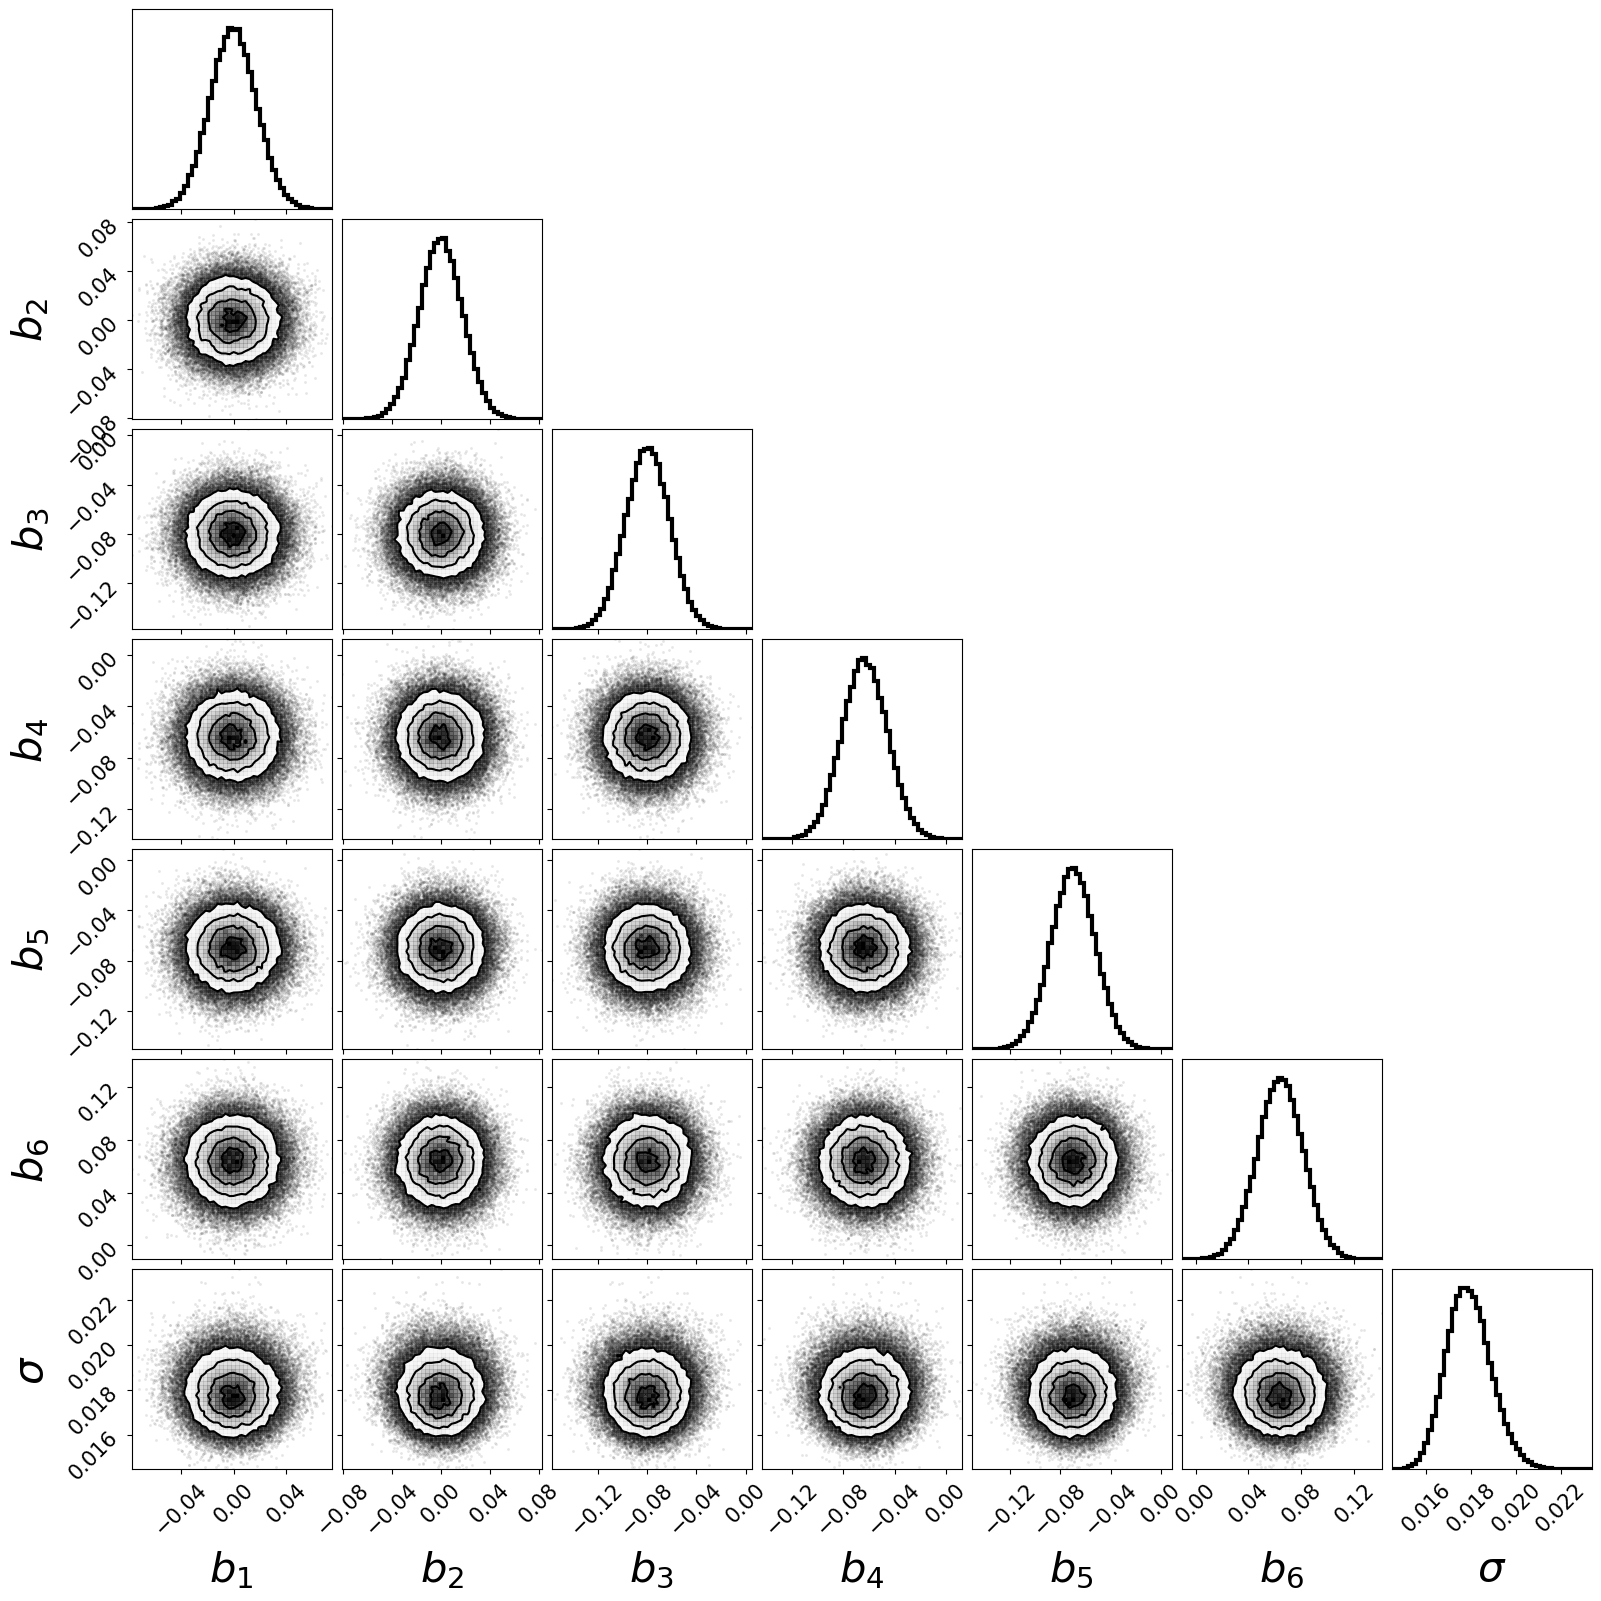

In [102]:
label_global = [f'$b_{i}$' for i in range(1,6+1)]
label_global.append(f'$\sigma$')

plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

figure = corner.corner(gibbs_sampler,bins=50, dpi=300, hist_kwargs={"linewidth": 3},
                       labels=label_global, 
                    #    truths=np.append(beta,np.sqrt(sigma_squared)),
                    #    truth_color="r",
                       label_kwargs={"fontsize": 30},labelpad=0.1)
plt.show()

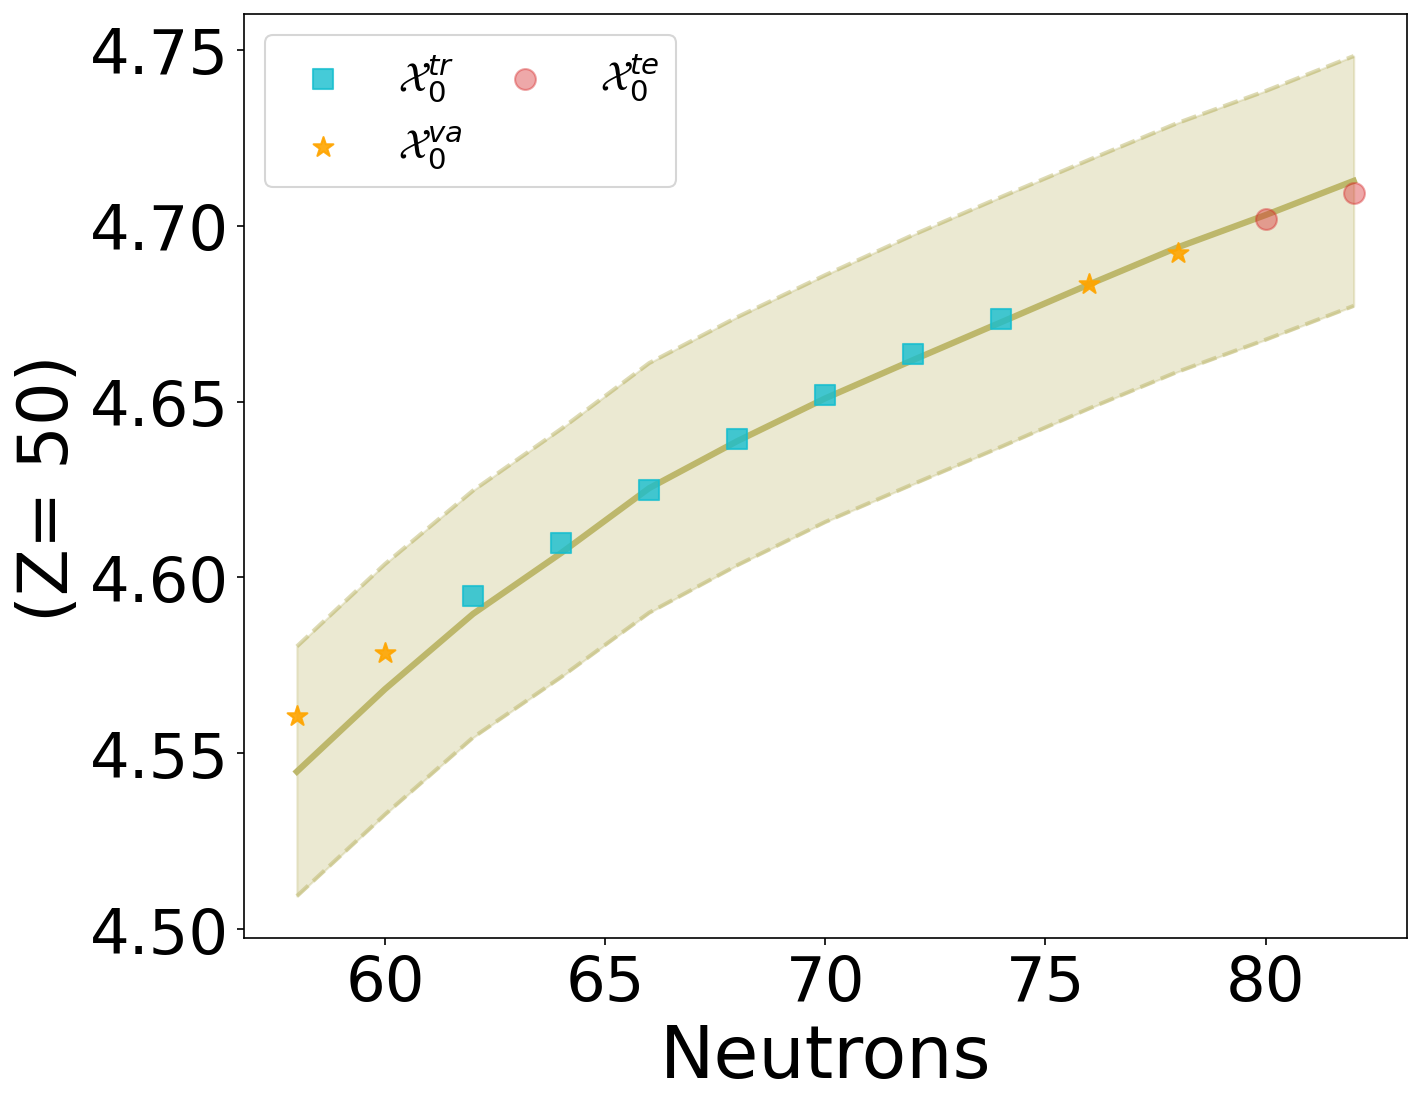

In [104]:
bmc.predict(train_index_radius, valid_index_radius, test_index_radius, 50, [0,300], models, gibbs_sampler, Vt_hat)